# ML Exploration

## Used functions created in Kevin's notebook to merge entire overview and rankings together and saved it as a csv

### 1. xgboost to predict player rank base on overall match stats

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

import warnings
warnings.filterwarnings("ignore")

base_dir = "C:/Users/Toast/Documents/GitHub/sta160"

## ranking_df

In [16]:
def ranking_df_creator(ranking_file_path):
    ranking_files_list = os.listdir(ranking_file_path)
    ranking_df = pd.DataFrame()
    col_names = ['date', 
               'year',
               'month',
               'day',
               'rank_text',
               'rank_number',
               'movement',
               'direction',
               'age',
               'points',
               'tournaments_played',
               'player_profile',
               'player_name',
               'player_id']
    
    for i in range(len(ranking_files_list)):
        tmp_df = pd.read_csv(str(ranking_file_path + ranking_files_list[i]), header = None, names = col_names)
        ranking_df = pd.concat([ranking_df, tmp_df])
    
    ranking_df['date'] = ranking_df['date'].replace('\.','/', regex=True)
    ranking_df['date'] = pd.to_datetime(ranking_df['date'])
    ranking_df = ranking_df.sort_values(by = 'date')
    ranking_df = ranking_df.reset_index(drop = True)
    
    return ranking_df

ranking_file_path = base_dir + '/Dataset/Cleaned Data/Rankings/'
ranking_df = ranking_df_creator(ranking_file_path)

In [18]:
ranking_df.to_csv(base_dir + '/Dataset/Cleaned Data/ranking.csv', index = None, header=True)

In [17]:
ranking_df.head(3)

,date,year,month,day,rank_text,rank_number,movement,direction,age,points,tournaments_played,player_profile,player_name,player_id
0,1973-08-23,1973,8,23,2,2,NaN,NaN,24.0,0,0,/en/players/manuel-orantes/o017/overview,manuel-orantes,o017
1,1973-08-23,1973,8,23,67,67,NaN,NaN,33.0,0,0,/en/players/bob%20-carmichael/c080/overview,bob%20-carmichael,c080
2,1973-08-23,1973,8,23,66,66,NaN,NaN,31.0,0,0,/en/players/juan-gisbert%20sr/g076/overview,juan-gisbert%20sr,g076


In [9]:
stats_overview_df = pd.read_csv(base_dir + '/Dataset/tennis_MatchChartingProject-master/charting-m-stats-Overview.csv')
stats_overview_df.head(3)

,match_id,player,set,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh
0,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,Total,69,2,1,32,25,37,21,5,4,63,36,28,10,16,16,6,9
1,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,2,Total,63,2,2,41,20,22,7,12,4,69,23,14,8,4,26,15,9
2,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,1,26,2,0,15,10,11,6,2,1,18,13,10,3,5,6,2,4


## match_id_split(), rank_merge() for stats_overview

* Working for last 15 but will take around an hour to run for the entire file

In [19]:
# %%time

def match_id_split(df):
    player1 = []
    player2 = []
    date = []
    year = []
    month = []
    
    for i in range(len(df)):
        df['match_id'] = df['match_id'].str.lower()
        df['match_id'] = df['match_id'].replace('_', '-', regex = True)
        match_id = df['match_id'].str.split('-')[i]
        
        player1.append(match_id[-4:][0] + '-' + match_id[-3:][0])
        player2.append(match_id[-2:][0] + '-' + match_id[-1:][0])
        
        date.append(match_id[0])
        year.append(match_id[0][:4])
        month.append(match_id[0][4:6])
        
    df['player1'] = player1
    df['player2'] = player2
    df['date'] = date
    df['year'] = year
    df['month'] = month
    
    date = []
    for i in range(len(df)):
        date.append('-'.join([df['date'][i][:4], df['date'][i][4:6], df['date'][i][6:]]))
    
    df['date'] = date
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    
    df = df.sort_values(by = 'date')
    df = df.reset_index(drop = True)
    
    return df

In [20]:
def rank_merge(df, ranking_df):
    player1 = df['player1'].tolist()
    player2 = df['player2'].tolist()
    
    year = df['year'].tolist()
    month = df['month'].tolist()
    
    player1_rank = []
    player2_rank = []
    
    for i in range(len(player1)):
        player1_df = ranking_df[ranking_df['player_name'] == player1[i]]
        player1_df = player1_df[(player1_df['year'] == int(year[i])) 
                                & (player1_df['month'] == int(month[i]))].reset_index(drop = True)
        try:
            player1_rank.append(player1_df['rank_number'][0])
        except KeyError as e:
            player1_rank.append(None)
        except IndexError as e:
            player1_rank.append(None)
        
        player2_df = ranking_df[ranking_df['player_name'] == player2[i]]
        player2_df = player2_df[(player2_df['year'] == int(year[i])) 
                                & (player2_df['month'] == int(month[i]))].reset_index(drop = True)
        try:
            player2_rank.append(player2_df['rank_number'][0])
        except KeyError as e:
            player2_rank.append(None)
        except IndexError as e:
            player2_rank.append(None)
    
    df['player1_rank'] = player1_rank
    df['player2_rank'] = player2_rank
    
    return df

In [21]:
#test_df = stats_overview_df.tail(15).reset_index(drop = True)
#cleaned_test_df = match_id_split(test_df)
#cleaned_test_df = rank_merge(cleaned_test_df, ranking_df)

cleaned_test_df = match_id_split(stats_overview_df)
cleaned_test_df = rank_merge(cleaned_test_df, ranking_df)

,match_id,player,set,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,...,unforced,unforced_fh,unforced_bh,player1,player2,date,year,month,player1_rank,player2_rank
0,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,2,13,0,1,7,0,6,1,...,8,2,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
1,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,1,38,0,1,23,13,15,10,...,9,3,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
2,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,1,28,0,0,18,10,10,4,...,11,6,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0


In [22]:
cleaned_test_df.to_csv(base_dir + '/Dataset/Cleaned Data/cleaned_stats_overview.csv', index = None, header=True)

### xgboost

In [4]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
match = pd.read_csv(base_dir + '/Dataset/Cleaned Data/stats_overview_merged.csv')

In [15]:
match.head(10)

,match_id,player,set,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,...,unforced,unforced_fh,unforced_bh,player1,player2,date,year,month,player1_rank,player2_rank
0,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,2,13,0,1,7,0,6,1,...,8,2,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
1,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,1,38,0,1,23,13,15,10,...,9,3,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
2,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,1,28,0,0,18,10,10,4,...,11,6,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
3,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,2,18,1,2,9,9,9,4,...,4,1,1,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
4,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,3,35,0,1,20,10,15,8,...,9,6,2,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
5,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,3,43,0,2,26,15,17,8,...,12,7,3,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
6,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,4,31,1,1,12,11,19,11,...,4,2,1,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
7,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,4,26,2,0,18,12,8,4,...,11,6,5,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
8,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,Total,110,2,3,69,37,41,17,...,42,21,18,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
9,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,Total,122,2,5,64,43,58,33,...,26,12,9,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0


In [6]:
total_match = match[match.set == 'Total']

In [17]:
total_match.head()

,match_id,player,set,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,...,unforced,unforced_fh,unforced_bh,player1,player2,date,year,month,player1_rank,player2_rank
8,19740714-m-bastad-f-bjorn-borg-adriano-panatta,2,Total,110,2,3,69,37,41,17,...,42,21,18,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
9,19740714-m-bastad-f-bjorn-borg-adriano-panatta,1,Total,122,2,5,64,43,58,33,...,26,12,9,bjorn-borg,adriano-panatta,1974-07-14,1974,7,9.0,38.0
18,19750101-m-australian-open-f-jimmy-connors-joh...,2,Total,133,17,7,83,66,50,23,...,25,8,10,jimmy-connors,john-newcombe,1975-01-01,1975,1,1.0,2.0
19,19750101-m-australian-open-f-jimmy-connors-joh...,1,Total,140,4,1,99,63,41,27,...,29,17,11,jimmy-connors,john-newcombe,1975-01-01,1975,1,1.0,2.0
20,19751219-m-davis-cup-world-group-f-rr-bjorn-bo...,1,Total,69,2,1,32,25,37,21,...,16,6,9,bjorn-borg,jiri-hrebec,1975-12-19,1975,12,3.0,53.0


In [7]:
last_5yr_total = total_match[total_match.year >= 2014]

I am only looking at the last five years of data to try and increase model accuracy because I think that trying to include player stats since 1974 would skew what the model perceives as rank 'x'

In [8]:
p1_total = last_5yr_total[last_5yr_total.player == 1]
p1_total.dropna(inplace=True)

In [9]:
p1_total.player1_rank[p1_total.player1_rank != 1] = 0

In [79]:
p1_total

,match_id,player,set,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,...,unforced,unforced_fh,unforced_bh,player1,player2,date,year,month,player1_rank,player2_rank
7077,20140101-m-brisbane-r16-jarkko-nieminen-roger-...,1,Total,62,2,5,35,21,27,13,...,17,5,7,jarkko-nieminen,roger-federer,2014-01-01,2014,1,0.0,6.0
7086,20140101-m-brisbane-r16-matthew-ebden-kei-nish...,1,Total,47,4,2,27,20,20,9,...,20,9,9,matthew-ebden,kei-nishikori,2014-01-01,2014,1,0.0,17.0
7087,20140101-m-brisbane-r16-marin-cilic-grigor-dim...,1,Total,77,14,4,46,40,31,16,...,30,13,13,marin-cilic,grigor-dimitrov,2014-01-01,2014,1,0.0,23.0
7100,20140101-m-doha-r16-rafael-nadal-tobias-kamke,1,Total,92,5,0,69,50,23,15,...,29,19,10,rafael-nadal,tobias-kamke,2014-01-01,2014,1,1.0,77.0
7103,20140102-m-brisbane-qf-roger-federer-marinko-m...,1,Total,41,9,1,25,20,16,10,...,10,7,2,roger-federer,marinko-matosevic,2014-01-02,2014,1,0.0,56.0
7107,20140102-m-doha-qf-ernests-gulbis-rafael-nadal,1,Total,72,9,3,46,34,26,9,...,35,16,16,ernests-gulbis,rafael-nadal,2014-01-02,2014,1,0.0,1.0
7113,20140102-m-brisbane-r16-lleyton-hewitt-felicia...,1,Total,80,10,2,44,33,36,20,...,19,11,6,lleyton-hewitt,feliciano-lopez,2014-01-02,2014,1,0.0,27.0
7124,20140103-m-brisbane-qf-marin-cilic-kei-nishikori,1,Total,117,14,11,51,37,66,32,...,66,26,29,marin-cilic,kei-nishikori,2014-01-03,2014,1,0.0,17.0
7132,20140103-m-sao-paulo-ch-qf-gastao-elias-facund...,1,Total,51,2,3,23,19,28,18,...,23,7,13,gastao-elias,facundo-arguello,2014-01-03,2014,1,0.0,120.0
7136,20140103-m-doha-sf-peter-gojowczyk-rafael-nadal,1,Total,84,1,4,46,29,38,17,...,32,16,12,peter-gojowczyk,rafael-nadal,2014-01-03,2014,1,0.0,1.0


In [10]:
p1_rank = p1_total.iloc[:, 25]

In [11]:
#p1_var = p1_total.iloc[:, 3:19]
p1_var = p1_total.iloc[:, 3:13]

In [12]:
# split data into X and y
X = p1_var
Y = p1_rank

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [83]:
X_train.head()

,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts
7163,82,2,0,62,45,20,17,5,4,87
9647,37,8,2,20,18,17,11,1,1,47
9579,83,0,3,58,36,25,15,6,3,88
7595,63,8,6,33,30,30,16,3,3,68
7360,86,5,2,53,36,33,19,7,4,77


In [35]:
# fit model no training data
model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=.8)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.8)

In [41]:
print(model)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)


In [ ]:
#"best from grid search"
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [36]:
# make predictions for test data
y_pred = model.predict(X_test)
#predictions = [round(value) for value in y_pred]

In [37]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.09%


In [38]:
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_pred)
auc_xg = auc(fpr_xg, tpr_xg)

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [14]:
mod = linear_model.LogisticRegression(solver="sag",max_iter=3000)
LR_model = mod.fit(X_train,y_train)
print("")
print("-----LR-----")
print("Testing Accuracy: ", LR_model.score(X_test, y_test))


-----LR-----
Testing Accuracy:  0.8565217391304348


In [15]:
y_predict_prob = LR_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_prob)
auc_lr = auc(fpr_lr, tpr_lr)

In [16]:
rf = RandomForestClassifier(max_depth=10, n_estimators=100)
rf.fit(X_train, y_train)
print("")
print("-----RF-----")
print("Testing Accuracy: ", rf.score(X_test, y_test))


-----RF-----
Testing Accuracy:  0.8652173913043478


In [17]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

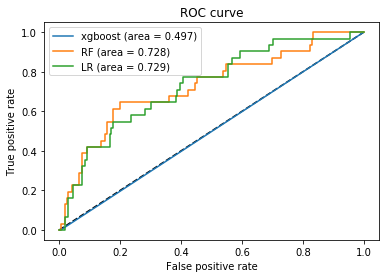

In [43]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xg, tpr_xg, label='xgboost (area = {:.3f})'.format(auc_xg))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC.png')
plt.show()

In [18]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [19]:
#collect all option permutations to use easily later on
class ANN_Options:
    def __init__(self, activation_function, num_nodes_per_hidden, num_hidden_layers, batch_size, learning_rate):
        self.activation_func = activation_function
        self.nodes_per_hidden = num_nodes_per_hidden
        self.num_hidden_layers = num_hidden_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
    def __str__(self):
        return str(self.activation_func) + " | hid nodes: " + str(self.nodes_per_hidden) + " | hid layers: " + str(self.num_hidden_layers) + " | batch size: " + str(self.batch_size) + " | learning rate: " + str(self.learning_rate)
    def writeToFile(self):
        return "ANN_Options(" + str(self.activation_func) + "|" + str(self.nodes_per_hidden) + "|" + str(self.num_hidden_layers) + "|" + str(self.batch_size) + "|" + str(self.learning_rate) + ")"

"""
    main function to build the ann
    X_TRAIN, Y_TRAIN = testing data
    X_TEST, Y_TEST   = testing data
    ann_options      = an instance of ANN_Options to specify the options for the ann
"""
def BuildAnn(X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, ann_options, verbose=True):
    model = Sequential()
    #input layer?
    model.add(Dense(ann_options.nodes_per_hidden, input_dim=X_TRAIN.shape[1], activation=ann_options.activation_func, use_bias=True))
    #hidden layers
    for n in range(0, ann_options.num_hidden_layers):
        model.add(Dense(ann_options.nodes_per_hidden, activation=ann_options.activation_func, use_bias=True))
    #output layer
    model.add(Dense(1,activation='sigmoid'))
    #stochastic gradient descent:
    optimizerSGD = SGD(lr=ann_options.learning_rate, momentum=0.9, decay=0.0, nesterov=True)

    model.compile(loss='binary_crossentropy', optimizer=optimizerSGD, metrics=['accuracy'])
    #model.compile(optimizer= 'adam', loss ="sparse_categorical_crossentropy", metrics = ['accuracy'])
    num_epochs = 30
    if (ann_options.learning_rate < 0.005):
        num_epochs = 100

    hist = model.fit(X_TRAIN, Y_TRAIN,
              epochs = num_epochs,
              batch_size = ann_options.batch_size,
              validation_data = (X_TEST, Y_TEST),
              verbose = verbose)    #verbose 0 silent, verbose 1 = progress bar

    #evalaute or predict
    training_res = model.evaluate(X_TRAIN, Y_TRAIN, batch_size=ann_options.batch_size, verbose=verbose)
    testing_res  = model.evaluate(X_TEST , Y_TEST , batch_size=ann_options.batch_size, verbose=verbose)

    # need to return the TRAINING LOSS, TRAINING ACCURACY, TESTING LOSS, TESTING ACCURACY, the HISTORY
    return (training_res[0], training_res[1], testing_res[0], testing_res[1], hist, model)


In [20]:
testing_options = ANN_Options('elu', 9, 3, 32, 0.1) #New new dataset settings
#testing_options = ANN_Options('relu', 10, 1, 32, 0.01)
print("Training: " + testing_options.writeToFile())
results = BuildAnn(X_train, y_train, X_test, y_test, testing_options, verbose=True)
model = results[5]

print("")
print("------Keras-----")
print("Training loss: ", results[0])
print("Training accuracy: ", results[1])
print("Testing loss: ", results[2])
print("Testing accuracy: ", results[3])

Training: ANN_Options(elu|9|3|32|0.1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 464 samples, validate on 230 samples
Epoch 1/30
464/464 [==============================] - 2s 5ms/step - loss: 2.2027 - acc: 0.8427 - val_loss: 2.1724 - val_acc: 0.8652
Epoch 2/30
464/464 [==============================] - 0s 170us/step - loss: 1.7716 - acc: 0.8901 - val_loss: 2.1724 - val_acc: 0.8652
Epoch 3/30
464/464 [==============================] - 0s 179us/step - loss: 1.7716 - acc: 0.8901 - val_loss: 2.1724 - val_acc: 0.8652
Epoch 4/30
464/464 [==============================] - 0s 164us/step - loss: 1.7716 - acc: 0.8901 - val_loss: 2.1724 - val_acc: 0.8652
Epoch 5/30
464/464 [==============================] - 0s 170us/step - loss: 1.7716 - acc: 0.8901 - val_loss: 2.1724 - val_acc: 0.8652
Epoch 6/30
464/464 [==============================] - 0s 177us/step - loss: 1.7716 - acc: 0.8901 - val_loss: 2.1724 - val_acc: 0

In [22]:
y_pred = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

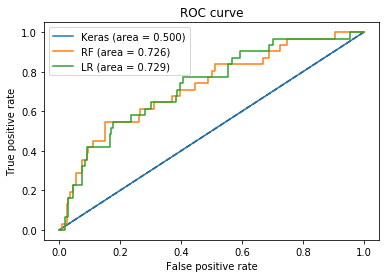

In [23]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC_keras.png')
plt.show()

In [27]:
prec_keras, rec_keras, _ = precision_recall_curve(y_test, y_pred)
auc_keras_pr = auc(rec_keras, prec_keras)

prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_pred_rf)
auc_rf_pr = auc(rec_rf, prec_rf)

prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_predict_prob)
auc_lr_pr = auc(rec_lr, prec_lr)

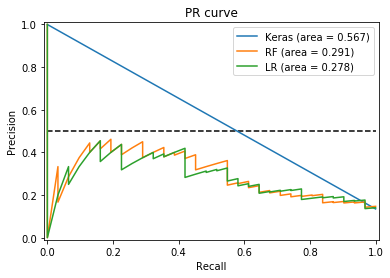

In [29]:
plt.figure(3)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(rec_keras, prec_keras, label='Keras (area = {:.3f})'.format(auc_keras_pr))
plt.plot(rec_rf, prec_rf, label='RF (area = {:.3f})'.format(auc_rf_pr))
plt.plot(rec_lr, prec_lr, label='LR (area = {:.3f})'.format(auc_lr_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.savefig('PR.png')
plt.show()

Gridsearch attempt

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 


In [12]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [15]:
from sklearn.externals import joblib
joblib.dump(optimized_GBM.best_estimator_, 'test1.pkl')

['test1.pkl']

In [39]:
optimized_GBM.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)